In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
grid_size = 50
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial
 
num_iterations = 30  # Number of iterations

# Initialize the grid and counts

counts = {0: grid_size * grid_size, 1: 0, 2: 0, 3: 0}

def initial_land_use(seed_number, grid_size, plot=False):
    np.random.seed(seed_number)
    
    grid = np.zeros((grid_size, grid_size), dtype=int)

    # Define initial conditions
    center_x, center_y = grid_size // 2, grid_size // 2
    
    # Randomly select positions for commercial cells
    commercial_cells = []
    num_commercial = 3
    min_dist_commercial = 1  # Minimum distance from center
    
    while len(commercial_cells) < num_commercial:
        x = np.random.randint(center_x - min_dist_commercial, center_x + min_dist_commercial + 1)
        y = np.random.randint(center_y - min_dist_commercial, center_y + min_dist_commercial + 1)
        if (x, y) not in commercial_cells:
            commercial_cells.append((x, y))

    residential_cells = []
    num_residential = 25
    min_dist = 3  # Minimum distance from commercial cells

    industrial_cells = []
    num_industrial = 4
    min_dist_industrial = 3  # Minimum distance from commercial cells

    # Generate random residential cells around the commercial area
    while len(residential_cells) < num_residential:
        x = np.random.randint(center_x - min_dist, center_x + min_dist + 1)
        y = np.random.randint(center_y - min_dist, center_y + min_dist + 1)
        if (x, y) not in commercial_cells:
            residential_cells.append((x, y))

    # Generate random industrial cells around the commercial area
    while len(industrial_cells) < num_industrial:
        x = np.random.randint(center_x - min_dist_industrial, center_x + min_dist_industrial + 1)
        y = np.random.randint(center_y - min_dist_industrial, center_y + min_dist_industrial + 1)
        if (x, y) not in commercial_cells:
            industrial_cells.append((x, y))

    # Assign initial land use types
    for x, y in commercial_cells:
        grid[x, y] = states['C']  # Commercial
    for x, y in residential_cells:
        grid[x, y] = states['H']  # Residential
    for x, y in industrial_cells:
        grid[x, y] = states['I']  # Industrial

    if plot:
        # Set the figure size
        plt.figure(figsize=(8, 8))
        cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
        plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
        plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
        plt.title('Initial Land Use')
        plt.show()

    return grid



In [6]:
weights_table = {
    'Vacant_Commerce': {
        'C': [25, 25, 25, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        'I': [0]*18,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Vacant_Industry': {
        'C': [0]*18,
        'I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        'H': [-1, -1, 0] + [0]*15,
        'V': [0]*18
    },
    'Vacant_Housing': {
        'C': [-2, -1, 2, 1, 1, 1, 0.5, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.1, 0, 0, 0, 0],
        'I': [-10, -10, -5, -3, -1] + [0]*13,
        'H': [2, 2, 1.5, 1.5, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1],
        'V': [0]*18
    },
    'Industry_Commerce': {
        'C': [25, 25, 25, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        'I': [-2, -2, -2] + [0]*15,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Industry_Industry': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
    'Industry_Housing': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
    'Housing_Commerce': {
        'C': [25, 25, 25, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        'I': [-10, -10, -5, -3, -1] + [0]*13,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Housing_Industry': {
        'C': [0]*18,
        'I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        'H': [-1, -1, 0] + [0]*15,
        'V': [0]*18
    },
    'Housing_Housing': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
}

# Test of accessing a weight:
transition = 'Vacant_Commerce'
cell_type = 'H'
distance_zone = 1
# This is distance zone is from 0 to 17
weight = weights_table[transition][cell_type][distance_zone]
print(f"The weight for transition={transition}, cell_type={cell_type}, distance_zone={distance_zone} is {weight}")


The weight for transition=Vacant_Commerce, cell_type=H, distance_zone=1 is 3.5


In [7]:

def get_distance_zone(distance):
    zone_mapping = {0: 1, 1: 1.4, 2: 2, 3: 2.2, 4: 2.8, 5: 3, 6: 3.2, 7: 3.6, 8: 4, 9: 4.1, 10: 4.2, 11: 4.5, 12: 5, 13: 5.1, 14: 5.4, 15: 5.7, 16: 5.8, 17: 6}
    for zone, max_distance in reversed(list(zone_mapping.items())):
        if distance >= max_distance:
            return zone
    return 0  # Return 0 if distance is less than the minimum specified distance

def get_neighbourhood(grid, row, col, radius):
    rows, cols = grid.shape
    square_row_range = range(max(0, row - radius), min(rows, row + radius + 1))
    square_col_range = range(max(0, col - radius), min(cols, col + radius + 1))
    square_neighbourhood = grid[np.ix_(square_row_range, square_col_range)]
    circle_mask = np.zeros_like(square_neighbourhood, dtype=bool)
    distance_zones = np.zeros_like(square_neighbourhood, dtype=int)
    # Adjusted center coordinates inside the neighbourhood
    center = min(row, radius), min(col, radius)
    for i in range(square_neighbourhood.shape[0]):
        for j in range(square_neighbourhood.shape[1]):
            distance = np.sqrt((center[0] - i) ** 2 + (center[1] - j) ** 2)
            if distance <= radius:
                circle_mask[i, j] = True
                distance_zones[i, j] = get_distance_zone(distance)
    circle_mask[center] = False  # Exclude the center cell
    return square_neighbourhood[circle_mask], distance_zones[circle_mask]




def cell_type_to_states(state):
    if state == 'Vacant':
        return 0
    elif state == 'Housing':
        return 1
    elif state == 'Industry':
        return 2
    elif state == 'Commerce':
        return 3

def states_to_cell_type(state):
    if state == 0:
        return 'V'
    elif state == 1:
        return 'H'
    elif state == 2:
        return 'I'
    elif state == 3:
        return 'C'


def calculate_transition_potentials(grid, alpha, weights_table, radius):
    transition_potentials = np.zeros((grid.shape[0], grid.shape[1], 4))  # 4 possible states
    transitions = ['Vacant_Commerce', 'Vacant_Industry', 'Vacant_Housing', 'Industry_Commerce', 'Industry_Industry',
                   'Industry_Housing', 'Housing_Commerce', 'Housing_Industry', 'Housing_Housing']
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            neighbourhood, distance_zones = get_neighbourhood(grid, i, j, radius)
            for transition in transitions:
                # Extract the current state and desired state from the transition string
                current_state, desired_state = transition.split('_')
                
                current_state_num = cell_type_to_states(current_state)
                desired_state_num = cell_type_to_states(desired_state)
                
            
                if grid[i, j] == current_state_num:
                    sum_weights = 0
                    for neighbor_state, distance_zone in zip(neighbourhood, distance_zones):
                        
                        neighbor_type = states_to_cell_type(neighbor_state)
                        
                        m_kd = weights_table[transition][neighbor_type][distance_zone]

                        if neighbor_state == desired_state_num:
                            sum_weights += m_kd

                    
                    R = np.random.uniform(0, 1)
                    S = 1 + (-math.log(R))**alpha
                    transition_potentials[i, j, desired_state_num] = S * (1 + sum_weights)
    return transition_potentials







In [6]:
test_grid = np.array([
    [3, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 2, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0],
])


alpha = 1

transition_potentials_test = calculate_transition_potentials(test_grid, alpha, weights_table, 2)
print("Transition Potentials:")
print(transition_potentials_test)




Transition Potentials:
[[[ 0.          0.          0.          0.        ]
  [ 0.          7.66412404  1.1492719  33.0375949 ]
  [ 0.          8.36355251  3.92407208 67.73659871]
  [ 0.          7.44688104  3.00485313  1.55827032]
  [ 0.          5.40999165  1.31706866  1.46587167]]

 [[ 0.         12.17722791  1.2354498  38.67326568]
  [ 0.          1.15400307  4.01855482 29.61557177]
  [ 0.          2.70987743  9.04221341  4.02018082]
  [ 0.          3.56104398  4.47710226  1.31769472]
  [ 0.         15.52900955  3.04937292  2.96896655]]

 [[ 0.          8.24161737  4.50751349 29.85909253]
  [ 0.          1.56652708  4.89764101  1.4996841 ]
  [ 0.          1.13115304  1.37908236  1.30713336]
  [ 0.          4.61432891  4.94535355  2.43079958]
  [ 0.         13.09875327  5.71605564  2.74434956]]

 [[ 0.         12.98097981  2.11996323  1.46455987]
  [ 0.          1.94104736 17.33417687  2.95850682]
  [ 0.          1.46969506 10.09147309  1.17374498]
  [ 0.          2.18978164  4.08672

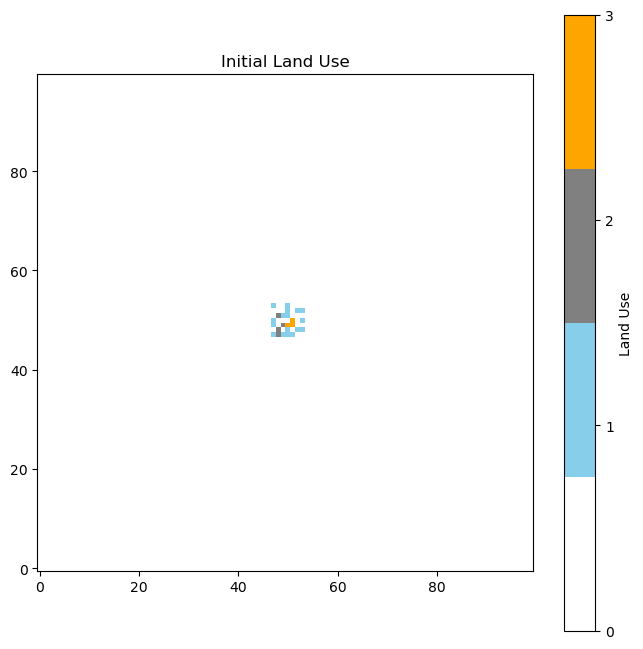

Initial counts: {0: 9976, 1: 17, 2: 4, 3: 3}
Running iteration 1...
Counts at iteration 1: {0: 9856, 1: 114, 2: 24, 3: 6}
Running iteration 2...
Counts at iteration 2: {0: 9735, 1: 213, 2: 43, 3: 9}
Running iteration 3...
Counts at iteration 3: {0: 9615, 1: 311, 2: 62, 3: 12}
Running iteration 4...
Counts at iteration 4: {0: 9494, 1: 409, 2: 82, 3: 15}
Running iteration 5...
Counts at iteration 5: {0: 9372, 1: 508, 2: 102, 3: 18}
Running iteration 6...
Counts at iteration 6: {0: 9253, 1: 605, 2: 121, 3: 21}
Running iteration 7...
Counts at iteration 7: {0: 9136, 1: 699, 2: 141, 3: 24}
Running iteration 8...
Counts at iteration 8: {0: 9017, 1: 796, 2: 160, 3: 27}
Running iteration 9...
Counts at iteration 9: {0: 8898, 1: 893, 2: 179, 3: 30}
Running iteration 10...
Counts at iteration 10: {0: 8777, 1: 991, 2: 199, 3: 33}
Running iteration 11...
Counts at iteration 11: {0: 8659, 1: 1087, 2: 218, 3: 36}
Running iteration 12...
Counts at iteration 12: {0: 8540, 1: 1183, 2: 238, 3: 39}
Runni

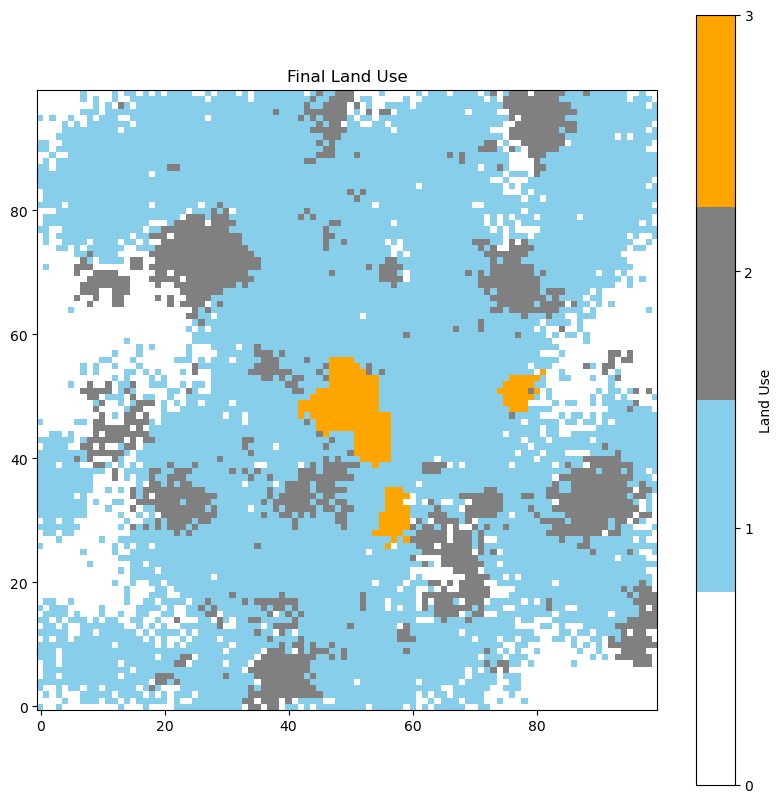

In [13]:
def run_simulation(grid, weights_table, alpha, growth_rates, radius, seed, num_iterations):
    np.random.seed(seed)
    grid_size = grid.shape[0]
    

    counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for i in range(grid_size):
        for j in range(grid_size):
            counts[grid[i, j]] += 1

    print(f"Initial counts: {counts}")

    for iteration in range(num_iterations):
        print(f"Running iteration {iteration+1}...")
        transition_potentials = calculate_transition_potentials(grid, alpha, weights_table, radius)

        highest_potentials = {}
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i, j] == states['V']:
                    potential_states = ['H', 'I', 'C']
                elif grid[i, j] == states['H']:
                    potential_states = ['I', 'C']
                elif grid[i, j] == states['I']:
                    potential_states = ['C']
                else:
                    potential_states = []
                    
                if potential_states:
                    highest_potentials[(i, j)] = max(potential_states, key=lambda state: transition_potentials[i, j, states[state]])

        for new_state_key in sorted(states, key=lambda k: states[k], reverse=True):
            new_state = states[new_state_key]
            if new_state_key != 'V':
                num_to_convert = int(grid_size * grid_size * growth_rates[new_state_key])
                potential_cells = [(i, j) for i, j in highest_potentials.keys() if highest_potentials[(i, j)] == new_state_key]
                potential_cells.sort(key=lambda cell: transition_potentials[cell[0], cell[1], states[highest_potentials[cell]]], reverse=True)
                
                for cell in potential_cells[:num_to_convert]:
                    counts[grid[cell]] -= 1
                    counts[new_state] += 1
                    grid[cell] = new_state

        print(f"Counts at iteration {iteration+1}: {counts}")

    plt.figure(figsize=(10, 10))
    cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
    plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
    plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
    plt.title('Final Land Use')
    plt.show()


growth_rates = {
    'H': 0.01,  
    'I': 0.002,
    'C': 0.00035,
}


num_iterations = 70
# Run the simulation
grid = initial_land_use(seed_number=0, grid_size=100, plot=True)
run_simulation(grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius = 6, seed=3, num_iterations=num_iterations)


In [90]:
import pandas as pd
from scipy.optimize import curve_fit
def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied rtype and unoccupied 0. """
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0;
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)
    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters

def power_law(x, a, b):
    return a * np.power(x, b)

In [411]:
def run_simulation_multiple(grid, weights_table, alpha, growth_rates, radius, seed, num_iterations):
    np.random.seed(seed)
    
    grid_size = grid.shape[0]
    powlaw_coef = np.zeros(num_iterations - 2)
    track_grid = np.zeros([num_iterations, grid_size, grid_size])
    track_grid[0] = grid
    for iteration in range(num_iterations):
        #print(f"Running iteration {iteration+1}...")
        transition_potentials = calculate_transition_potentials(grid, alpha, weights_table, radius)

        highest_potentials = {}
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i, j] == states['V']:
                    potential_states = ['H', 'I', 'C']
                elif grid[i, j] == states['H']:
                    potential_states = ['I', 'C']
                elif grid[i, j] == states['I']:
                    potential_states = ['C']
                else:
                    potential_states = []
                    
                if potential_states:
                    highest_potentials[(i, j)] = max(potential_states, key=lambda state: transition_potentials[i, j, states[state]])

        for new_state_key in sorted(states, key=lambda k: states[k], reverse=True):
            new_state = states[new_state_key]
            if new_state_key != 'V':
                num_to_convert = int(grid_size * grid_size * growth_rates[new_state_key])
                potential_cells = [(i, j) for i, j in highest_potentials.keys() if highest_potentials[(i, j)] == new_state_key]
                potential_cells.sort(key=lambda cell: transition_potentials[cell[0], cell[1], states[highest_potentials[cell]]], reverse=True)
                for cell in potential_cells[:num_to_convert]:
                    grid[cell] = new_state

        if iteration > 2: # run the clustering
            clusters = run_clustering(grid)
            cluster1 = clusters[clusters.cell_type == 1]
            pars1, cov1 = curve_fit(f=power_law, xdata=cluster1.Cluster_size, ydata=cluster1.Cluster_count, p0=[np.max(cluster1.Cluster_size), -1.8])
            powlaw_coef[iteration-5] = pars1[1]
        
        track_grid[iteration] = grid
    """
    plt.figure(figsize=(10, 10))
    cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
    plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
    plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
    plt.title('Final Land Use')
    plt.show()
    """
    return grid, powlaw_coef, track_grid
    
"""
# make seed to be 10 random integers from 0 to 100000
seeds = np.random.randint(0, 100000, 10)

growth_rates = {
    'H': 0.01,  
    'I': 0.002,
    'C': 0.00035,
}
num_iterations = 50

for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    new_grid = initial_land_use(seed_number=seed, grid_size=grid_size, plot=True)
    run_simulation_multiple(new_grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius=6, seed=seed, num_iterations=num_iterations)
    print("Simulation completed.\n")

"""

'\n# make seed to be 10 random integers from 0 to 100000\nseeds = np.random.randint(0, 100000, 10)\n\ngrowth_rates = {\n    \'H\': 0.01,  \n    \'I\': 0.002,\n    \'C\': 0.00035,\n}\nnum_iterations = 50\n\nfor seed in seeds:\n    print(f"Running simulation with seed {seed}...")\n    new_grid = initial_land_use(seed_number=seed, grid_size=grid_size, plot=True)\n    run_simulation_multiple(new_grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius=6, seed=seed, num_iterations=num_iterations)\n    print("Simulation completed.\n")\n\n'

In [430]:
import powerlaw

def test_power_law(clusters):
    """
    Test the power law against alternative distributions and run p-value. 
    """
    # Create the list
    clus_list = []

    for index, row in x.iterrows():
        for c in range(int(row.Cluster_count)):
            clus_list.append(row.Cluster_size)
    
    fit = powerlaw.Fit(clus_list, discrete=True)
    alpha = fit.power_law.alpha
    expon_test = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    str_exp_test = fit.distribution_compare('power_law', 'stretched_exponential')
    trunc_pl_test = fit.distribution_compare('power_law', 'truncated_power_law')
    log_norm_test = fit.distribution_compare('power_law', 'lognormal')
    log_norm_test2 = fit.distribution_compare('power_law', 'lognormal_positive')
    test_count = np.where([expon_test[1], str_exp_test[1], trunc_pl_test[1], log_norm_test[1], log_norm_test2[1]] < 0.05, 1, 0).count()
    return [alpha, expon_test, str_exp_test, trunc_pl_test, log_norm_test, log_norm_test2, test_count] 



In [463]:

growth_rates = {
    'H': 0.01,  
    'I': 0.002,
    'C': 0.005,
}

grid_size, num_iterations = 100, 50
seeds = np.random.randint(0, 100000, 1)
grid_results = np.zeros([len(seeds), grid_size, grid_size])
prop_results = np.zeros([len(seeds), num_iterations, 4])
pow_law_arr = np.zeros([num_iterations-2,len(seeds)])

for seed in range(len(seeds)):
    new_grid = initial_land_use(seed_number=seeds[seed], grid_size=grid_size, plot=False)
    grid, count_array, track_grid = run_simulation_multiple(new_grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius=6, seed=4567, num_iterations=num_iterations)
    #grid_results[seed] = grid

    #pow_law_arr[:,seed] = powlaw
    #print(seed)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


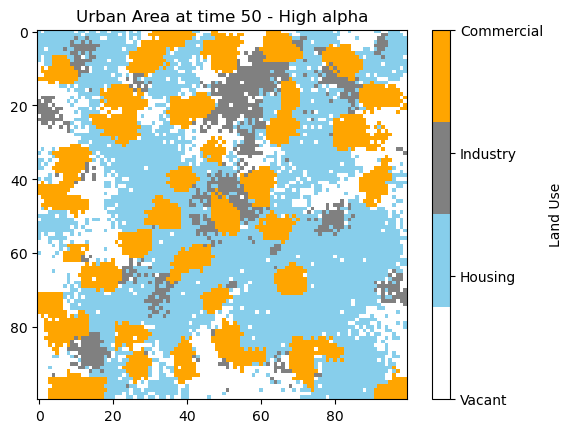

In [467]:
from matplotlib import animation

def gs_animation(frames, track_grid):
    """
    INPUT: frames - how many frames to animate over.
    """
    def init():
        plt.clf()
        plt.imshow(track_grid[0], cmap = cmap, vmin = 0, vmax = 3)
        cbar = plt.colorbar(ticks=[0,1,2,3], label='Land Use')
        cbar.set_ticklabels(['Vacant','Housing','Industry', 'Commercial'])
        plt.title(f'Urban Area at time 1 - High alpha')
    # animation function.  This is called sequentially
    def animate(i):
        plt.clf()
        plt.imshow(track_grid[i], cmap = cmap, vmin = 0, vmax = 3)
        cbar = plt.colorbar(ticks=[0,1,2,3], label='Land Use')
        cbar.set_ticklabels(['Vacant','Housing','Industry', 'Commercial'])
        plt.title(f'Urban Area at time {i+1} - High alpha')
        
    # First set up the figure, the axis, and the plot element we want to animate    
    fig = plt.figure()
    cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
    plt.imshow(track_grid[0], cmap = cmap, vmin = 0, vmax = 3)
    cbar = plt.colorbar(ticks=[0,1,2,3], label='Land Use')
    cbar.set_ticklabels(['Vacant','Housing','Industry', 'Commercial'])
    plt.title(f'Urban Area at time 1')
    # call the animator. blit=True means only re-draw the parts that have changed.
    # Frames refers to how many images it will use in the animation. 
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=5, blit = False)
    writer = animation.PillowWriter(fps=4, metadata=dict(artist='Me'), bitrate=1800)
    anim.save("urban_dev_high_alpha.gif", writer=writer)
    
gs_animation(50, track_grid)